100%|██████████| 100/100 [00:00<00:00, 1684.40it/s]
c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Accuracy: 0.8022222222222222


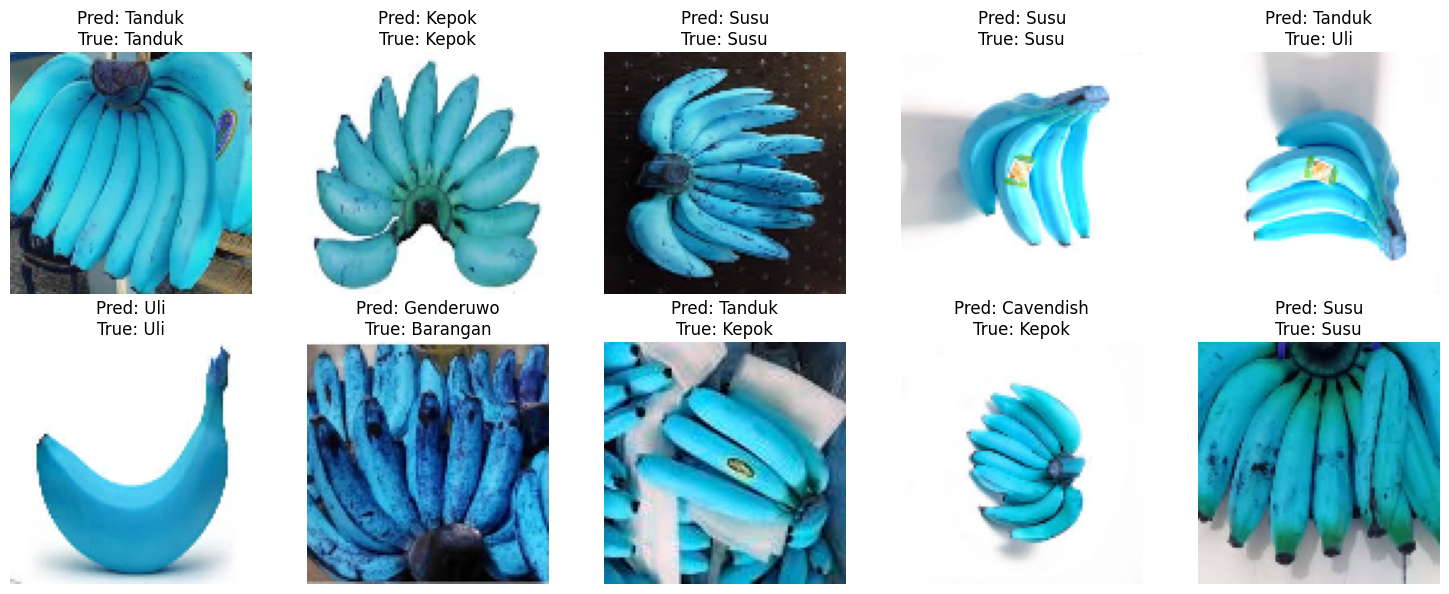

In [22]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import random

AMBON_DIR = 'ambon'
BARANGAN_DIR = 'barangan'
CAVENDISH_DIR = 'cavendish'
GENDERUWO_DIR = 'genderuwo'
JAVAICECREAM_DIR = 'javaicecream'
KEPOK_DIR = 'kepok'
MAS_DIR = 'mas'
NANGKA_DIR = 'nangka'
RAJA_DIR = 'raja'
SUSU_DIR = 'susu'
TANDUK_DIR = 'tanduk'
ULI_DIR = 'uli'

def load_images(DIR, label):
    images = []
    labels = []
    for img_name in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (100, 100))
        img = img.astype('float32') / 255.0  # nOrMaLIzE
        images.append(img)
        labels.append(label)

    
        flipped_img = cv2.flip(img, 1)
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        images.append(flipped_img)
        labels.append(label)
        images.append(rotated_img)
        labels.append(label)
    return images, labels

X_ambon, y_ambon = load_images(AMBON_DIR, 'Ambon')
X_barangan, y_barangan = load_images(BARANGAN_DIR, 'Barangan')
X_cavendish, y_cavendish = load_images(CAVENDISH_DIR, 'Cavendish')
X_genderuwo, y_genderuwo = load_images(GENDERUWO_DIR, 'Genderuwo')
X_javaicecream, y_javaicecream = load_images(JAVAICECREAM_DIR, 'Javaicecream')
X_kepok, y_kepok = load_images(KEPOK_DIR, 'Kepok')
X_mas, y_mas = load_images(MAS_DIR, 'Mas')
X_nangka, y_nangka = load_images(NANGKA_DIR, 'Nangka')
X_raja, y_raja = load_images(RAJA_DIR, 'Raja')
X_susu, y_susu = load_images(SUSU_DIR, 'Susu')
X_tanduk, y_tanduk = load_images(TANDUK_DIR, 'Tanduk')
X_uli, y_uli = load_images(ULI_DIR, 'Uli')

X = X_ambon + X_barangan + X_cavendish + X_genderuwo + X_javaicecream + X_kepok + X_mas + X_nangka + X_raja + X_susu + X_tanduk + X_uli
y = y_ambon + y_barangan + y_cavendish + y_genderuwo + y_javaicecream + y_kepok + y_mas + y_nangka + y_raja + y_susu + y_tanduk + y_uli

X = np.array(X)
y = np.array(y)

def extract_color_histogram(image):
    chans = cv2.split(image)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return np.array(features)

def extract_texture(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 24, 8, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_shape(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

def extract_edge(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    prewitt_x = cv2.filter2D(gray, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))
    prewitt_y = cv2.filter2D(gray, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]))
    edges = np.sqrt(prewitt_x**2 + prewitt_y**2)
    hist = cv2.calcHist([edges.astype('uint8')], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_threshold(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    hist = cv2.calcHist([thresh], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_morphology(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(gray, kernel, iterations=1)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    
    features = []
    for morph in [erosion, dilation, opening, closing]:
        hist = cv2.calcHist([morph], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return np.array(features)

def extract_features(images):
    features = []
    for img in images:
        color_features = extract_color_histogram(img)
        texture_features = extract_texture(img)
        shape_features = extract_shape(img)
        edge_features = extract_edge(img)
        threshold_features = extract_threshold(img)
        morphology_features = extract_morphology(img)
        combined_features = np.hstack([color_features, texture_features, shape_features, edge_features, threshold_features, morphology_features])
        features.append(combined_features)
    return np.array(features)

X_features = extract_features(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

x_train, x_test, y_train, y_test = train_test_split(X_features_scaled, y_encoded, test_size=0.25, random_state=42)

param_grid = {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 6, 8, 10, 12]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

best_rf = grid_search.best_estimator_
best_rf.fit(x_train, y_train)

y_pred = best_rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        idx = random.randint(0, len(x_test) - 1)
        ax[i, j].imshow(X[idx])
        ax[i, j].set_title(f"Pred: {le.inverse_transform([y_pred[idx]])[0]}\nTrue: {le.inverse_transform([y_test[idx]])[0]}")
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()
